Librairies

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error



Loading and supercial exploration of datasets

In [28]:
pokemons_df = pd.read_csv('pokemon.csv', header= 0, index_col="#")
battles_df = pd.read_csv('combats.csv', header= 0)
print(pokemons_df.head())
print(pokemons_df.describe())
print(pokemons_df.info())
print(battles_df.head())
print(battles_df.describe())
print(battles_df.info())

            Name Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  \
#                                                                               
1      Bulbasaur  Grass  Poison  45      49       49       65       65     45   
2        Ivysaur  Grass  Poison  60      62       63       80       80     60   
3       Venusaur  Grass  Poison  80      82       83      100      100     80   
4  Mega Venusaur  Grass  Poison  80     100      123      122      120     80   
5     Charmander   Fire     NaN  39      52       43       60       50     65   

   Generation  Legendary  
#                         
1           1      False  
2           1      False  
3           1      False  
4           1      False  
5           1      False  
               HP      Attack     Defense     Sp. Atk     Sp. Def       Speed  \
count  800.000000  800.000000  800.000000  800.000000  800.000000  800.000000   
mean    69.258750   79.001250   73.842500   72.820000   71.902500   68.277500   


Data Preparation: Duplicates

In [29]:
print(pokemons_df[pokemons_df.duplicated()])
#No duplicates in pokemons_df

#We consider that duplicates in battle_df merely mean they fought several times.
#Thus we won't deduplicate.

Empty DataFrame
Columns: [Name, Type 1, Type 2, HP, Attack, Defense, Sp. Atk, Sp. Def, Speed, Generation, Legendary]
Index: []


Data Preparation: Missing values

In [30]:
#In feature 'Name' of pokemons_df, we have a missing value to be replaced by 'Primeape' value
pokemons_df.loc[pokemons_df['Name'].isnull(), 'Name'] = 'Primeape'

#In feature 'Type 2' we need to replace NANs with 'None'
pokemons_df['Type 2'] = pokemons_df['Type 2'].fillna('None')

print(pokemons_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 1 to 800
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        800 non-null    object
 1   Type 1      800 non-null    object
 2   Type 2      800 non-null    object
 3   HP          800 non-null    int64 
 4   Attack      800 non-null    int64 
 5   Defense     800 non-null    int64 
 6   Sp. Atk     800 non-null    int64 
 7   Sp. Def     800 non-null    int64 
 8   Speed       800 non-null    int64 
 9   Generation  800 non-null    int64 
 10  Legendary   800 non-null    bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 69.5+ KB
None


Data Preparation: Calculate each Pokemon’s win percentage using the combat data.

In [ ]:
# Count total number of battles for each Pokémon (as First or Second)
total_combats = pd.concat([
    battles_df['First_pokemon'],
    battles_df['Second_pokemon']
]).value_counts().sort_index()

# Count number of victories per Pokémon (column Winner)
victoires = battles_df['Winner'].value_counts().sort_index()

# Build dataframe with this intel
win_stats = pd.DataFrame({
    'Total_Combats': total_combats,
    'Victoires': victoires
}).fillna(0)

# Calculate Win Percentage
win_stats['Win_Percentage'] = 100 * win_stats['Victoires'] / win_stats['Total_Combats']

# Add to pokemons_df
pokemons_df = pokemons_df.join(win_stats).reset_index()

# Replace NANs (Pokémon without a fight) with 0
pokemons_df['Win_Percentage'] = pokemons_df['Win_Percentage'].fillna(0)
pokemons_df['Total_Combats'] = pokemons_df['Total_Combats'].fillna(0).astype(int)
pokemons_df['Victoires'] = pokemons_df['Victoires'].fillna(0).astype(int)

pokemons_df.head()


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Total_Combats,Victoires,Win_Percentage
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,133,37,27.819549
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,121,46,38.016529
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,132,89,67.424242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,125,70,56.000000
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,False,112,55,49.107143


Exploratory Analysis & Visualization

                      HP    Attack     Speed  Win_Percentage
HP              1.000000  0.422386  0.175952        0.234889
Attack          0.422386  1.000000  0.381240        0.476675
Speed           0.175952  0.381240  1.000000        0.905409
Win_Percentage  0.234889  0.476675  0.905409        1.000000


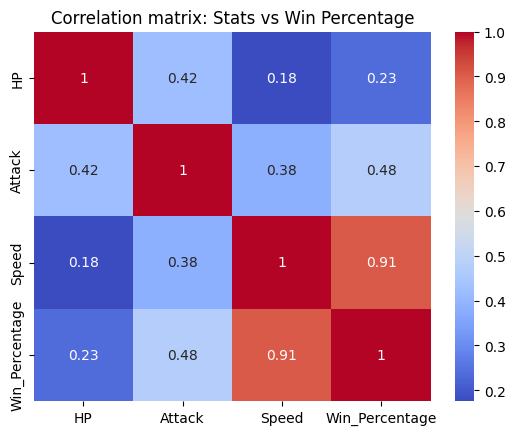

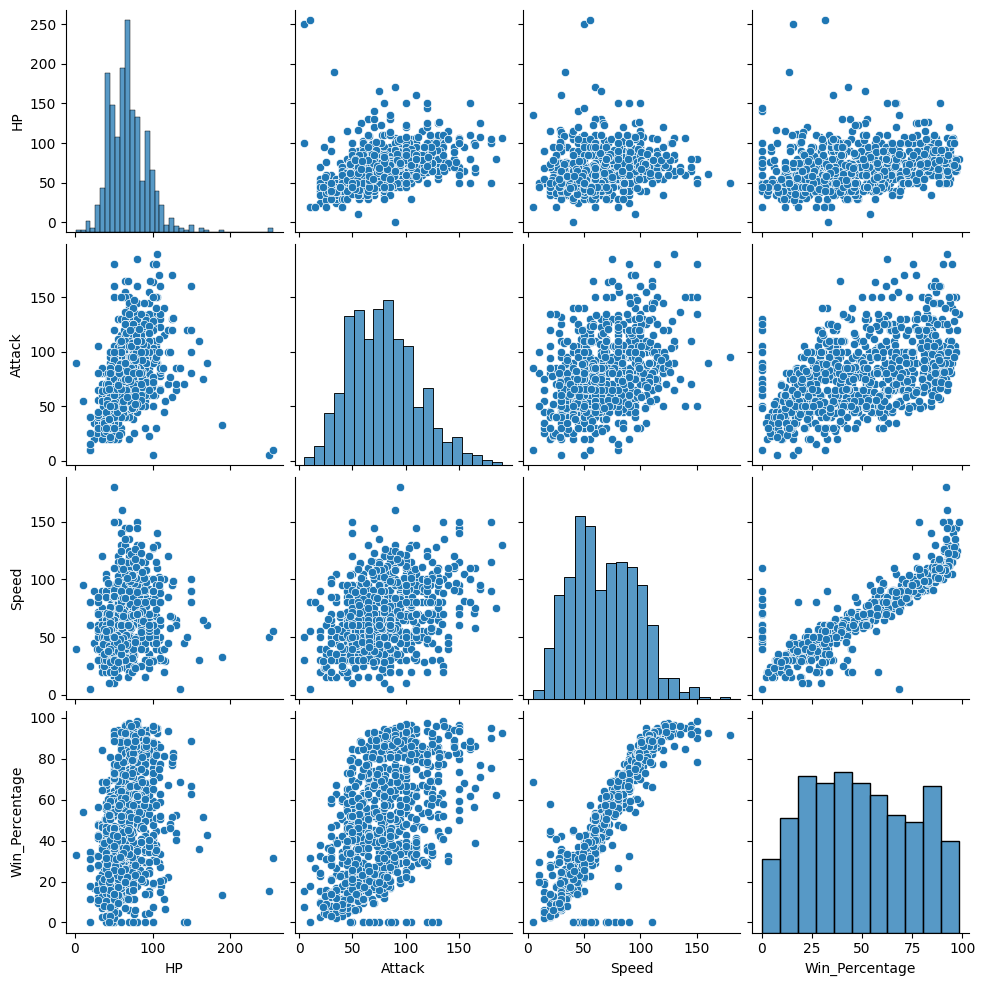

                         Name  Win_Percentage   HP  Attack  Speed
154           Mega Aerodactyl       98.449612   80     135    150
512                   Weavile       97.478992   70     120    125
703    Tornadus Therian Forme       96.800000   79     100    121
19              Mega Beedrill       96.638655   65     150    145
153                Aerodactyl       96.453901   80     105    130
476              Mega Lopunny       96.124031   65     136    135
726                  Greninja       96.062992   72      95    122
716  Meloetta Pirouette Forme       95.934959  100     128    128
164             Mega Mewtwo Y       95.200000  106     150    140
349             Mega Sharpedo       95.000000   70     140    105


In [ ]:
# Correlation matrix on stats and Win_Percentage
cols_of_interest = ['HP', 'Attack', 'Speed', 'Win_Percentage']
corr_matrix = pokemons_df[cols_of_interest].corr()
print(corr_matrix)

# Heatmap of correlation
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix: Stats vs Win Percentage')
plt.show()

# Pairplot to visualize relationship between stats and win percentage
sns.pairplot(pokemons_df[cols_of_interest])
plt.show()

# Top 10 Pokémons by Win_Percentage
top_10 = pokemons_df.sort_values('Win_Percentage', ascending=False).head(10)
print(top_10[['Name', 'Win_Percentage', 'HP', 'Attack', 'Speed']])

#Speed seems to be the most correlated stat with victory and with low variability
#Attack shows lesser correlation. Yet it might be related to it's grearter variability
#Finally, HP doesn't show as high a correlation


Machine Learning

In [39]:
#Split data into training/testing sets (80/20 split).
features = ['HP', 'Attack', 'Defense']
X = pokemons_df[features]
y = pokemons_df['Win_Percentage']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#Train and evaluate 3 regression models (e.g., Linear Regression, Random Forest, XGBoost) to predict win percentage.
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, eval_metric='mae')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    results[name] = mae
    print(f"{name} MAE: {mae:.4f}")

#Compare model performance using Mean Absolute Error (MAE).
baseline_pred = [y_train.mean()] * len(y_test)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print("Baseline MAE:", baseline_mae)



Linear Regression MAE: 18.5825
Random Forest MAE: 18.2780
XGBoost MAE: 19.1328
Baseline MAE: 21.748205103049195


The Mean Absolute Error (MAE) values around 18 indicate that, on average, our models predict each Pokémon’s win percentage within ±18 percentage points of the actual value. Compared to the baseline MAE of about 21.75, which corresponds to always predicting the average win rate, this represents a meaningful improvement.

Among the three models tested—Linear Regression, Random Forest, and XGBoost—Random Forest achieved the lowest MAE, suggesting it captures the relationship between Pokémon stats and win rates best on this dataset. However, the difference with Linear Regression is small, and further validation with techniques like cross-validation and hyperparameter tuning is recommended to confirm these findings.

Overall, while predicting Pokémon win rates from basic stats is challenging due to the complexity of battle dynamics, our models demonstrate promising predictive power and provide a solid foundation for further enhancements.